The dataset provided for this assignment consists of readings from four sensors in one hundred turbofan jet engines as they approach failure, with the aim of building both a regression model to predict the remaining cycles in the life of the engine, and a binary classification model to highlight when an engine is in its last 30 operational cycles.

A number of approaches to this have been pursued, including exploration of the data, pre-processing, feature selection, model selection, and hyperparameter tuning.

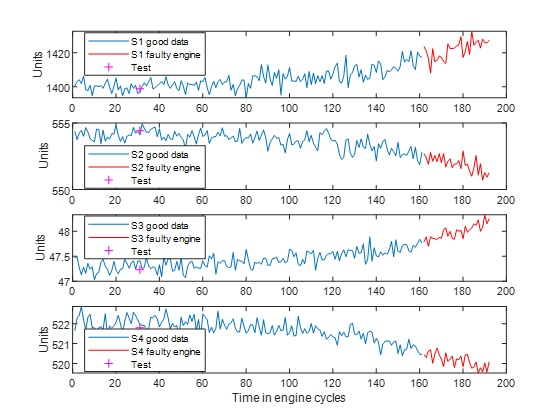 


# A1 Histogram Plots

Initial investigations into the dataset began with generating histograms of sensor output across the full dataset, to get an initial idea of the range and distribution of each, as seen in below. This shows reasonable consistency across the engines – a promising start – with smooth distributions over a relatively narrow range of sensor readings. It can be seen immediately that a degree of scaling will be required, as the disparity between the median reading for sensor 1 at 1408 and sensor 3 at 47.5 would for some algorithms cause inappropriate weighting towards sensor 1. 

,id,cycle,s1,s2,s3,s4,ttf,label_bnc
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,1408.933782,553.367711,47.541168,521.413470,107.807862,0.150259
std,29.227633,68.880990,9.000605,0.885092,0.267087,0.737553,68.880990,0.357334
min,1.000000,1.000000,1382.250000,549.850000,46.850000,518.690000,0.000000,0.000000
25%,26.000000,52.000000,1402.360000,552.810000,47.350000,520.960000,51.000000,0.000000
50%,52.000000,104.000000,1408.040000,553.440000,47.510000,521.480000,103.000000,0.000000
75%,77.000000,156.000000,1414.555000,554.010000,47.700000,521.950000,155.000000,0.000000
max,100.000000,362.000000,1441.490000,556.060000,48.530000,523.380000,361.000000,1.000000


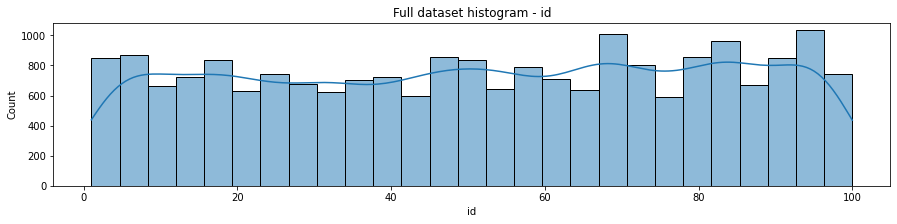

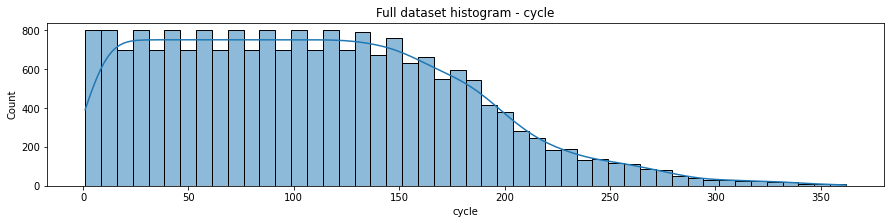

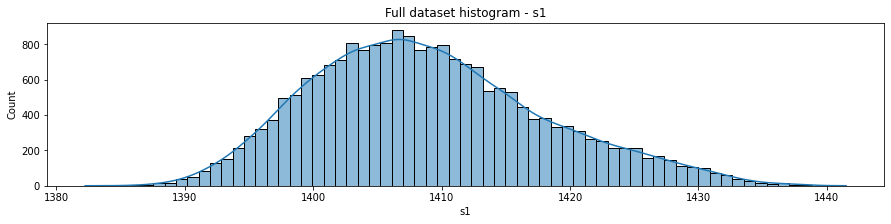

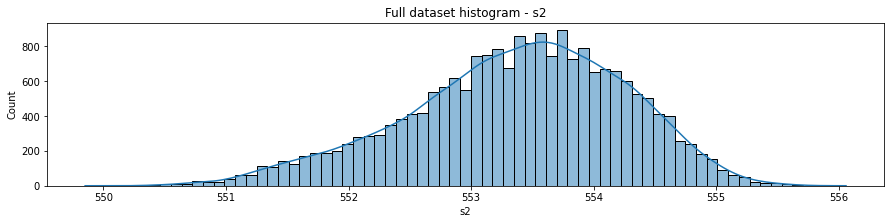

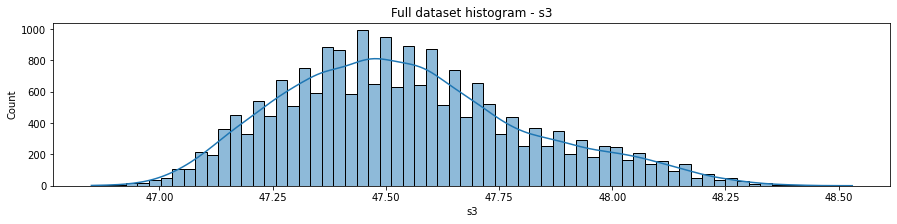

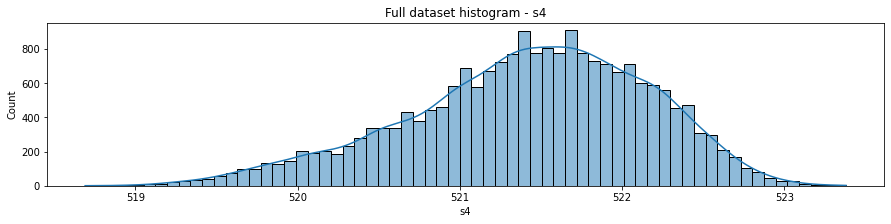

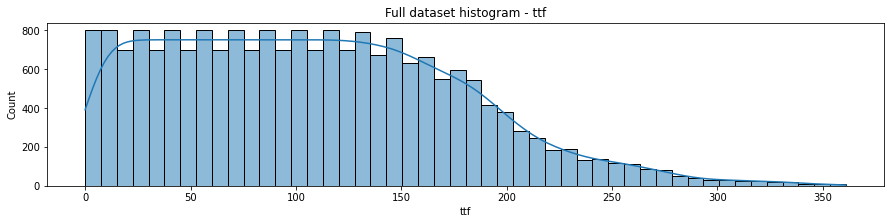

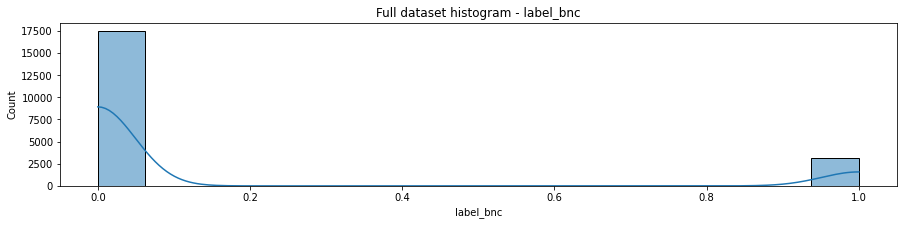

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

data = pd.read_csv("train_selected.csv")

for column in data:
    plt.figure(figsize=(15,3))
    hist = seaborn.histplot(data=data, x=column, kde=True)
    hist.set_title("Full dataset histogram - {}".format(column))

data.describe()

# A2 Raw All-Up Plots

As shown here the sensor signals contain a significant quantity of noise. It is anticipated that for many algorithms this will negatively impact accuracy, and hence a degree of filtering or smoothing would be beneficial. 

Investigating options for smoothing these lines introduced an important point that would recur throughout the project – that the training data is in the form of continuous time domain data, following each sensor over time until engine failure, but the test data is made up of single points. It is generally important practice that any pre-processing carried out on the training data is applied consistently with the test data, but any line smoothing applied will inherently be based on the time domain, treating each sensor as a line rather than a collection of individual points. As such this will not be applicable to individual points of test data but may show overall improvements even despite this asymmetry.

Investigating options for smoothing these lines introduced an important point that would recur throughout the project – that the training data is in the form of continuous time domain data, following each sensor over time until engine failure, but the test data is made up of single points. It is generally important practice that any pre-processing carried out on the training data is applied consistently with the test data, but any line smoothing applied will inherently be based on the time domain, treating each sensor as a line rather than a collection of individual points. As such this will not be applicable to individual points of test data but may show overall improvements even despite this asymmetry.

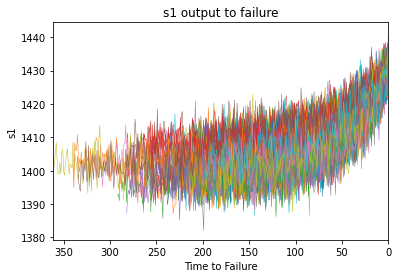

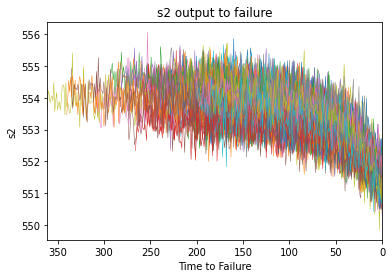

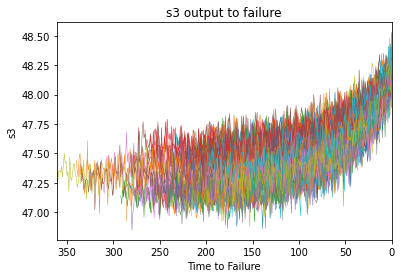

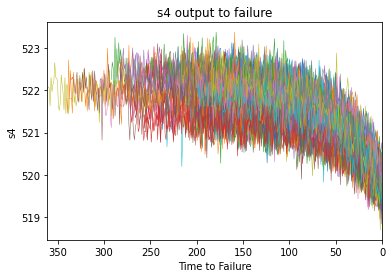

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("train_selected.csv")
engines = data.groupby("id")

ttf_max = data["ttf"].max()
ttf_min = data["ttf"].min()

sensors = ["s1","s2","s3","s4"]

for s in sensors:
    for engine, group in engines:
        plt.plot(group["ttf"],group[s],linewidth=0.5)
    plt.xlabel("Time to Failure")
    plt.ylabel("{}".format(s))
    plt.xlim(ttf_max,ttf_min)
    plt.title("{} output to failure".format(s))
    plt.show()

# A3 Example Smoothed Plot

This shows the sensor 1 output for engine one, both raw and after smoothing using the Savitzky-Golay algorithm, which finds a polynomial fit within a sliding window. 

Note that the noise becomes more aggressive towards engine failure – this is not a feature which can be investigated with snapshot test data but might be an interesting angle for a model permitted to use full time-domain data.


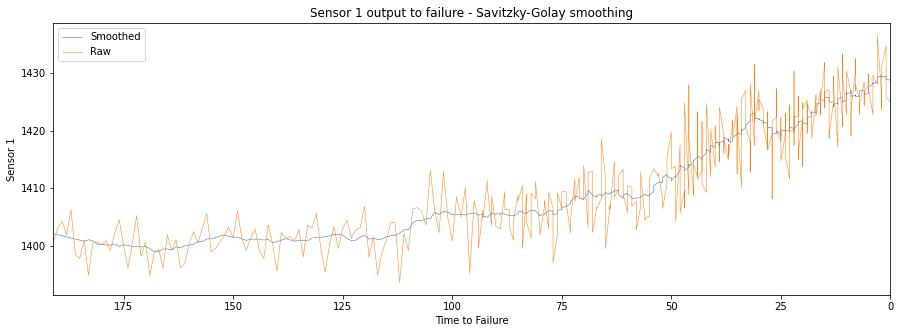

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

data = pd.read_csv("train_selected.csv")
engines = data.groupby("cycle")
e1 = engines.first().sort_values(by="ttf",ascending=False)
ttf_max = e1["ttf"].max()
ttf_min = e1["ttf"].min()

plt.figure(figsize=(15,5))
plt.plot(e1["ttf"],
        savgol_filter(e1["s1"],15,1),
        linewidth=0.5,label="Smoothed")
plt.plot(e1["ttf"],e1['s1'],linewidth=0.5,label="Raw")
plt.xlabel("Time to Failure")
plt.ylabel("Sensor 1")
plt.xlim(ttf_max,ttf_min)
plt.title("Sensor 1 output to failure - Savitzky-Golay smoothing")
plt.legend()
plt.show()

# A4 Smoothed All-Up Plots and Noise Distribution

The data shown here is the equivalent of the raw plots, after noise reduction with the Savitzky-Golay filter, as calculated with a window length of 15, and 1st order polynomials. Overall patterns are much more clearly visible. 

Also generated are plots of noise distribution against the smoothed signal – in each case a strongly normal distribution, indicating that the smoothing process should not introduce any bias. Wile it may still impact accuracy, this can be proven at a later stage. Each model investigated for both regression and classification will be checked against both smoothed and unsmoothed data.

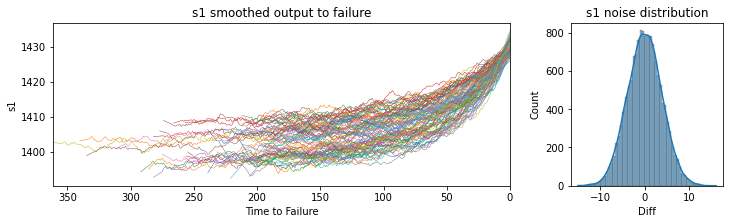

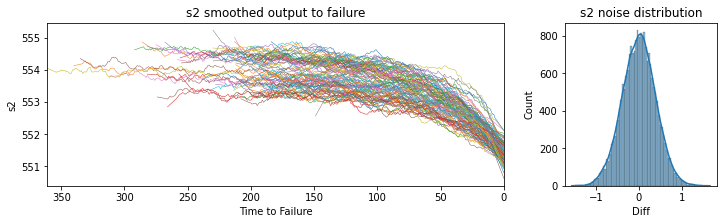

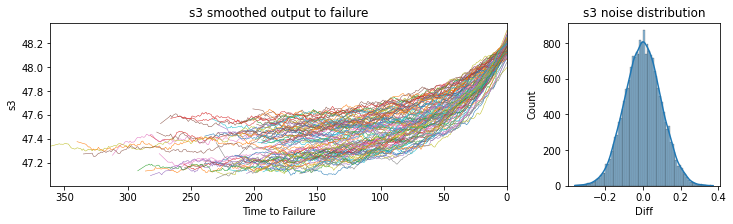

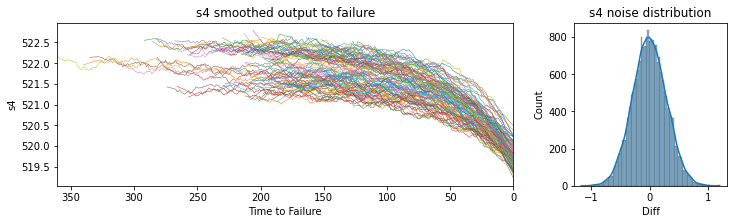

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn

data = pd.read_csv("train_selected.csv")
ttf_max = data["ttf"].max()
ttf_min = data["ttf"].min()
engines = data.groupby("id")

sensors = ["s1","s2","s3","s4"]
for sensor in sensors:
    diff = list()
    smooth, raw = list(), list()
    for engine, group in engines:
        smooth.extend(savgol_filter(group[sensor],15,1))
        raw.extend(group[sensor])
    for s, r in zip(smooth,raw): diff.append(s-r)
    data = pd.DataFrame(diff,columns=["Diff"])
    f, (ax1,ax2) = plt.subplots(ncols=2,
                               figsize=(12,3),
                                gridspec_kw={'width_ratios': [3, 1]})
    ax2 = seaborn.histplot(data=data, x="Diff", kde=True)
    ax2.set_title("{} noise distribution".format(sensor))

    for engine, group in engines:
        ax1.plot(group["ttf"],
                 savgol_filter(group[sensor],15,1),
                linewidth=0.5)
    ax1.set_xlabel("Time to Failure")
    ax1.set_ylabel("{}".format(sensor))
    ax1.set_xlim(ttf_max,ttf_min)
    ax1.set_title("{} smoothed output to failure".format(sensor))

    plt.show()   

# Polynomial Features Output

Text(0.5, 1.0, 'Number of polynomial features generated')

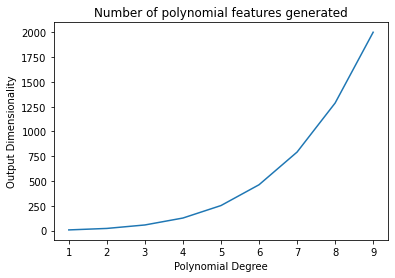

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

a = np.array([3,5,7,11,13]).reshape(1,-1)
x = range(1,10)
y = [len(PolynomialFeatures(degree=n).fit_transform(a)[0]) for n in x ]

plt.plot(x,y)
plt.xlabel("Polynomial Degree")
plt.ylabel("Output Dimensionality")
plt.title("Number of polynomial features generated")

# A5 Example Scaling

Across each data type, the range of figures was centred about zero and scaled to unit variance. Hence for each data point x, the scaled data point z was produced such that:

z=  (x-Mean)/(Standard Deviation)

Both mean and standard deviation are calculated from the training data, and then applied to test data. An example of this can be seen below – the line is visually identical between the raw and scaled data, but reduced to the range of -2 to 2. Some algorithms, such as Tree or Random Forest approaches, are unaffected by this scaling, but others such as KNNs are strongly affected, as otherwise data with higher ranges will be disproportionately weighted in the distance calculations. No approach was found which performed worse after scaling, and as a result this was applied universally, for consistency.


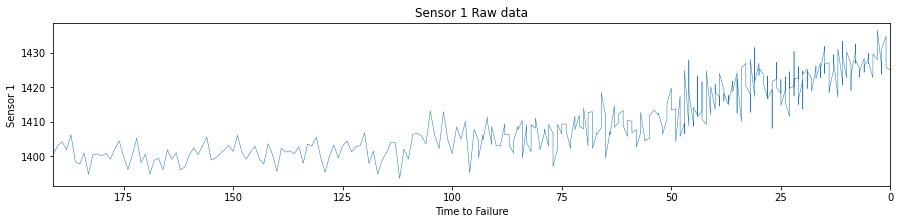

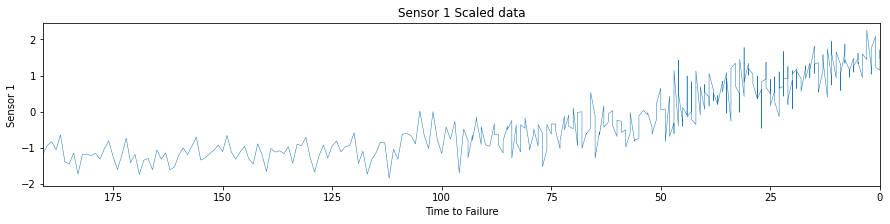

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

data = pd.read_csv("train_selected.csv")
engines = data.groupby("cycle")
e1 = engines.first().sort_values(by="ttf",ascending=False)
ttf_max = e1["ttf"].max()
ttf_min = e1["ttf"].min()

plt.figure(figsize=(15,3))
plt.plot(e1["ttf"],e1['s1'],linewidth=0.5,label="Raw")
plt.xlabel("Time to Failure")
plt.ylabel("Sensor 1")
plt.xlim(ttf_max,ttf_min)
plt.title("Sensor 1 Raw data")
plt.show()

s1 = np.array(e1["s1"]).reshape(-1,1)
s1_scaled = StandardScaler().fit_transform(s1)
plt.figure(figsize=(15,3))
plt.plot(e1["ttf"],s1_scaled,linewidth=0.5,label="Raw")
plt.xlabel("Time to Failure")
plt.ylabel("Sensor 1")
plt.xlim(ttf_max,ttf_min)
plt.title("Sensor 1 Scaled data")
plt.show()

# Principle Components Analysis

Depending on the algorithm used, higher dimensionality data can be a significant impediment to both accuracy and training times, as the complexity of the data space increases exponentially. This can be a particular issue for Nearest Neighbour approaches, as increasing the dimensionality of the space also greatly increases data sparsity across that space – a problem known as the Curse of Dimensionality. Principle Component Analysis is a form of dimensionality reduction, that projects the inputted data onto a lower dimensional space in such a way as to preserve the maximum possible variance within that data. Within this pipeline it is used as a form of antidote to the dimensional explosion of the polynomial feature extraction.

This reduction is an inherently lossy process. This plot shows the proportion of variance in the data explained by the calculated PCA components, from the training dataset and its polynomial features to the fourth degree, resulting in 126 dimensional data. Post-PCA, the vast majority of the data variance is represented by four or five components, with limited returns for component counts above five.

(20631, 5)
(20631, 126)
(8, 126)
(8,)


([<matplotlib.axis.XTick at 0x7f6ee59e80>,
 <a list of 8 Text major ticklabel objects>)

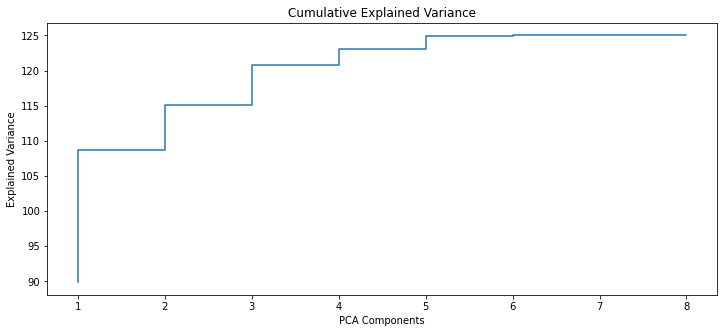

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import numpy as np

data = pd.read_csv("train_selected.csv")
X_train = data[["cycle","s1","s2","s3","s4"]]
a_poly = PolynomialFeatures(degree=4).fit_transform(X_train)
a_scale = StandardScaler().fit_transform(a_poly)
a_pca = PCA(n_components=8).fit(a_scale)

y = a_pca.explained_variance_.cumsum()
x = np.arange(1,len(y)+1)
plt.figure(figsize=(12,5))
plt.step(x,y)
plt.title("Cumulative Explained Variance")
plt.xlabel("PCA Components")
plt.ylabel("Explained Variance")
plt.xticks(x)